In [2]:
import io, os, sys, types
import pprint
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell


import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC

from sklearn.model_selection import(
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV,
)


from sklearn import preprocessing

from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    LassoCV,
    ElasticNetCV,
    LinearRegression
)

from sklearn.feature_selection import(
    f_regression,
    SelectKBest,
    SelectFromModel
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

#modules for pca & classification portion

from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
import itertools

from scipy.stats import skew

import pickle
#import xgboost
from sklearn.externals import joblib

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Initializing the dataset
We'll want to apply the same transformations we make on train to test, that way, running a test model won't require going back to make changes to the data. To do this, we'll join the two dataframes.

In [1076]:
data = pd.concat(objs=[train, test], axis=0)

# Visualizing Missingness
We'll use a useful tool from the missingno libary to graph NA values. 

UnboundLocalError: local variable 'ax2' referenced before assignment

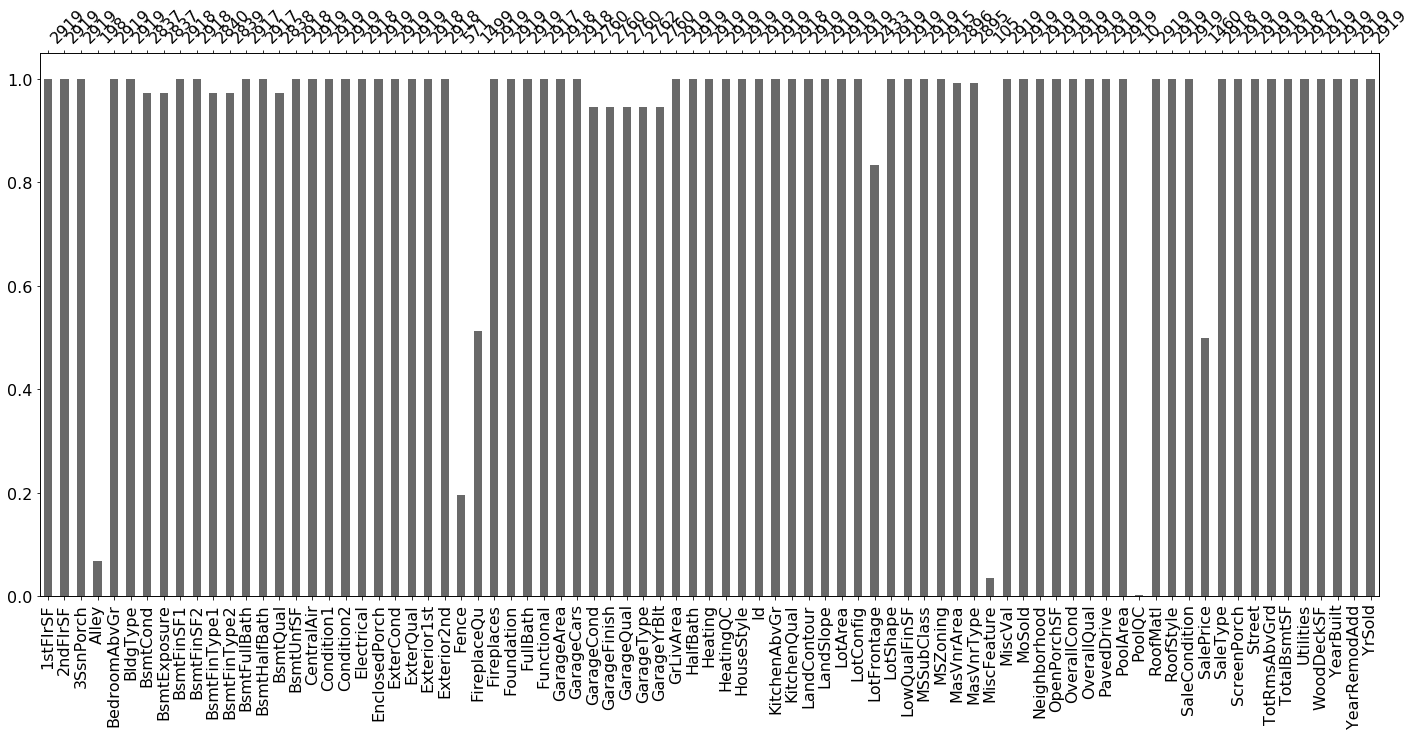

In [737]:
msno.bar(data)

The reason for Nan values can vary from column to column. Understanding this will help with imputation.

In [738]:
def return_nas(df):
    return df.columns[df.isnull().any()]
with_nas = return_nas(data)
print("Columns with missing values:\n {}".format(with_nas))
data[with_nas].head()

Columns with missing values:
 Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF',
       'Utilities'],
      dtype='object')


,Alley,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,...,LotFrontage,MSZoning,MasVnrArea,MasVnrType,MiscFeature,PoolQC,SalePrice,SaleType,TotalBsmtSF,Utilities
0,NaN,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,...,65.0,RL,196.0,BrkFace,NaN,NaN,208500.0,WD,856.0,AllPub
1,NaN,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,...,80.0,RL,0.0,None,NaN,NaN,181500.0,WD,1262.0,AllPub
2,NaN,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,...,68.0,RL,162.0,BrkFace,NaN,NaN,223500.0,WD,920.0,AllPub
3,NaN,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,...,60.0,RL,0.0,None,NaN,NaN,140000.0,WD,756.0,AllPub
4,NaN,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,...,84.0,RL,350.0,BrkFace,NaN,NaN,250000.0,WD,1145.0,AllPub


Some of the columns can have their NA values be converted to 0, an average/median/mode, or a category: "None".  
With others, we can try to get a little clever by looking into the data description.

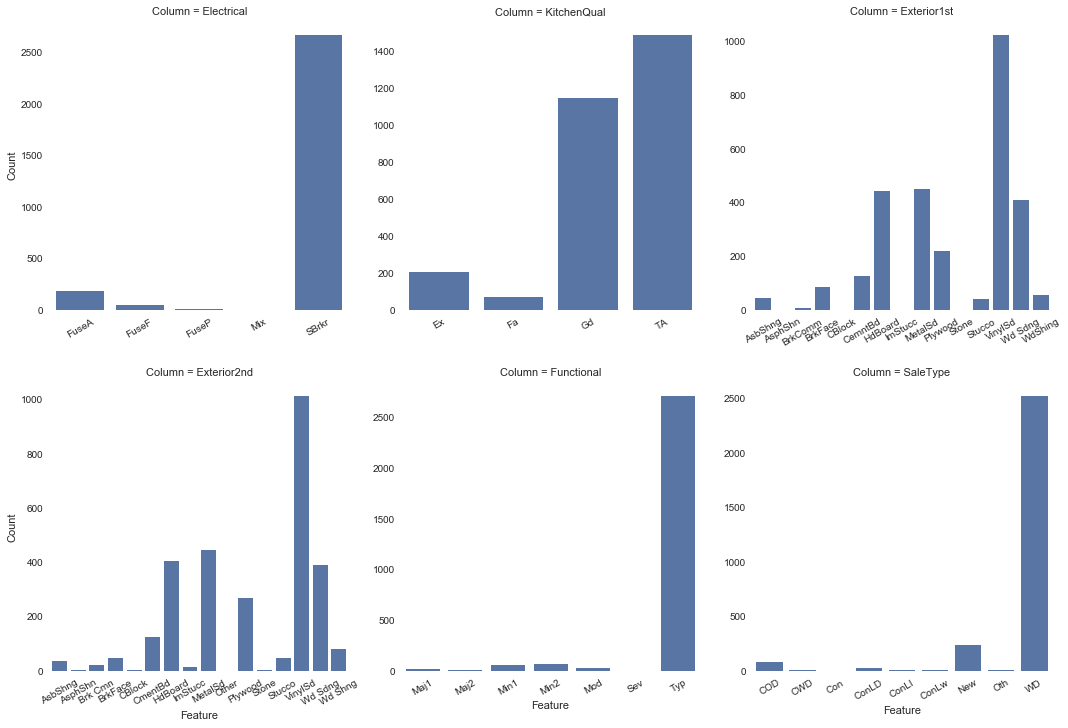

In [1077]:
to_mode = [
    "Electrical", "KitchenQual", "Exterior1st",
    "Exterior2nd", "Functional", "SaleType"
]
P = pd.Series()
for i in range(len(to_mode)):
    df = pd.DataFrame(data.groupby(to_mode[i]).size())
    df["Column"] = str(to_mode[i])
    P = pd.concat([P, df], axis=0)
P.reset_index(inplace=True)
P.rename(index=str, columns={"index":"Feature", 0:"Count"}, inplace=True)

g = sns.FacetGrid(P, col="Column", col_wrap = 3, size = 5, sharex=False , sharey=False)
g = g.map(sns.barplot, "Feature", "Count", data=P)
g.fig.tight_layout(h_pad=3.5)
# Label rotation
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)

The mode values seem like good guesses for NA values, considering the mode is the overwhelming majority in these features.

In [1078]:
to_None = [
    "Alley","BsmtCond", "BsmtExposure",
    "MiscFeature", "PoolQC","Fence",
    "FireplaceQu", "BsmtQual",
    "BsmtFinType1", "BsmtFinType2",
    "GarageType", "GarageFinish",
    "GarageCond", "GarageQual",
    "MasVnrType"
]
data[to_None] = data[to_None].fillna("None", axis=1)

to_0 = [
    "MasVnrArea", "GarageYrBlt", "GarageArea",
    "GarageCars", "BsmtFinSF1", "BsmtFinSF2"
]
data[to_0] = data[to_0].fillna(0, axis=1)

# Convert certain na's to their node values
for col in to_mode:
    data[col] = data[col].fillna(data[col].mode()[0])
        
# Missing GarageYrBlt will have the same year the house was built
data['GarageYrBlt'].fillna(data['YearBuilt'], inplace=True)
# Median lot frontage by neighborhood
data["LotFrontage"].fillna(data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())), inplace=True)

## Detecting outliers
With use of a scatter plot, we can find outliers that won't be helpful for training our model.  
Note: This step is easier to perform before applying any normalization to the data.

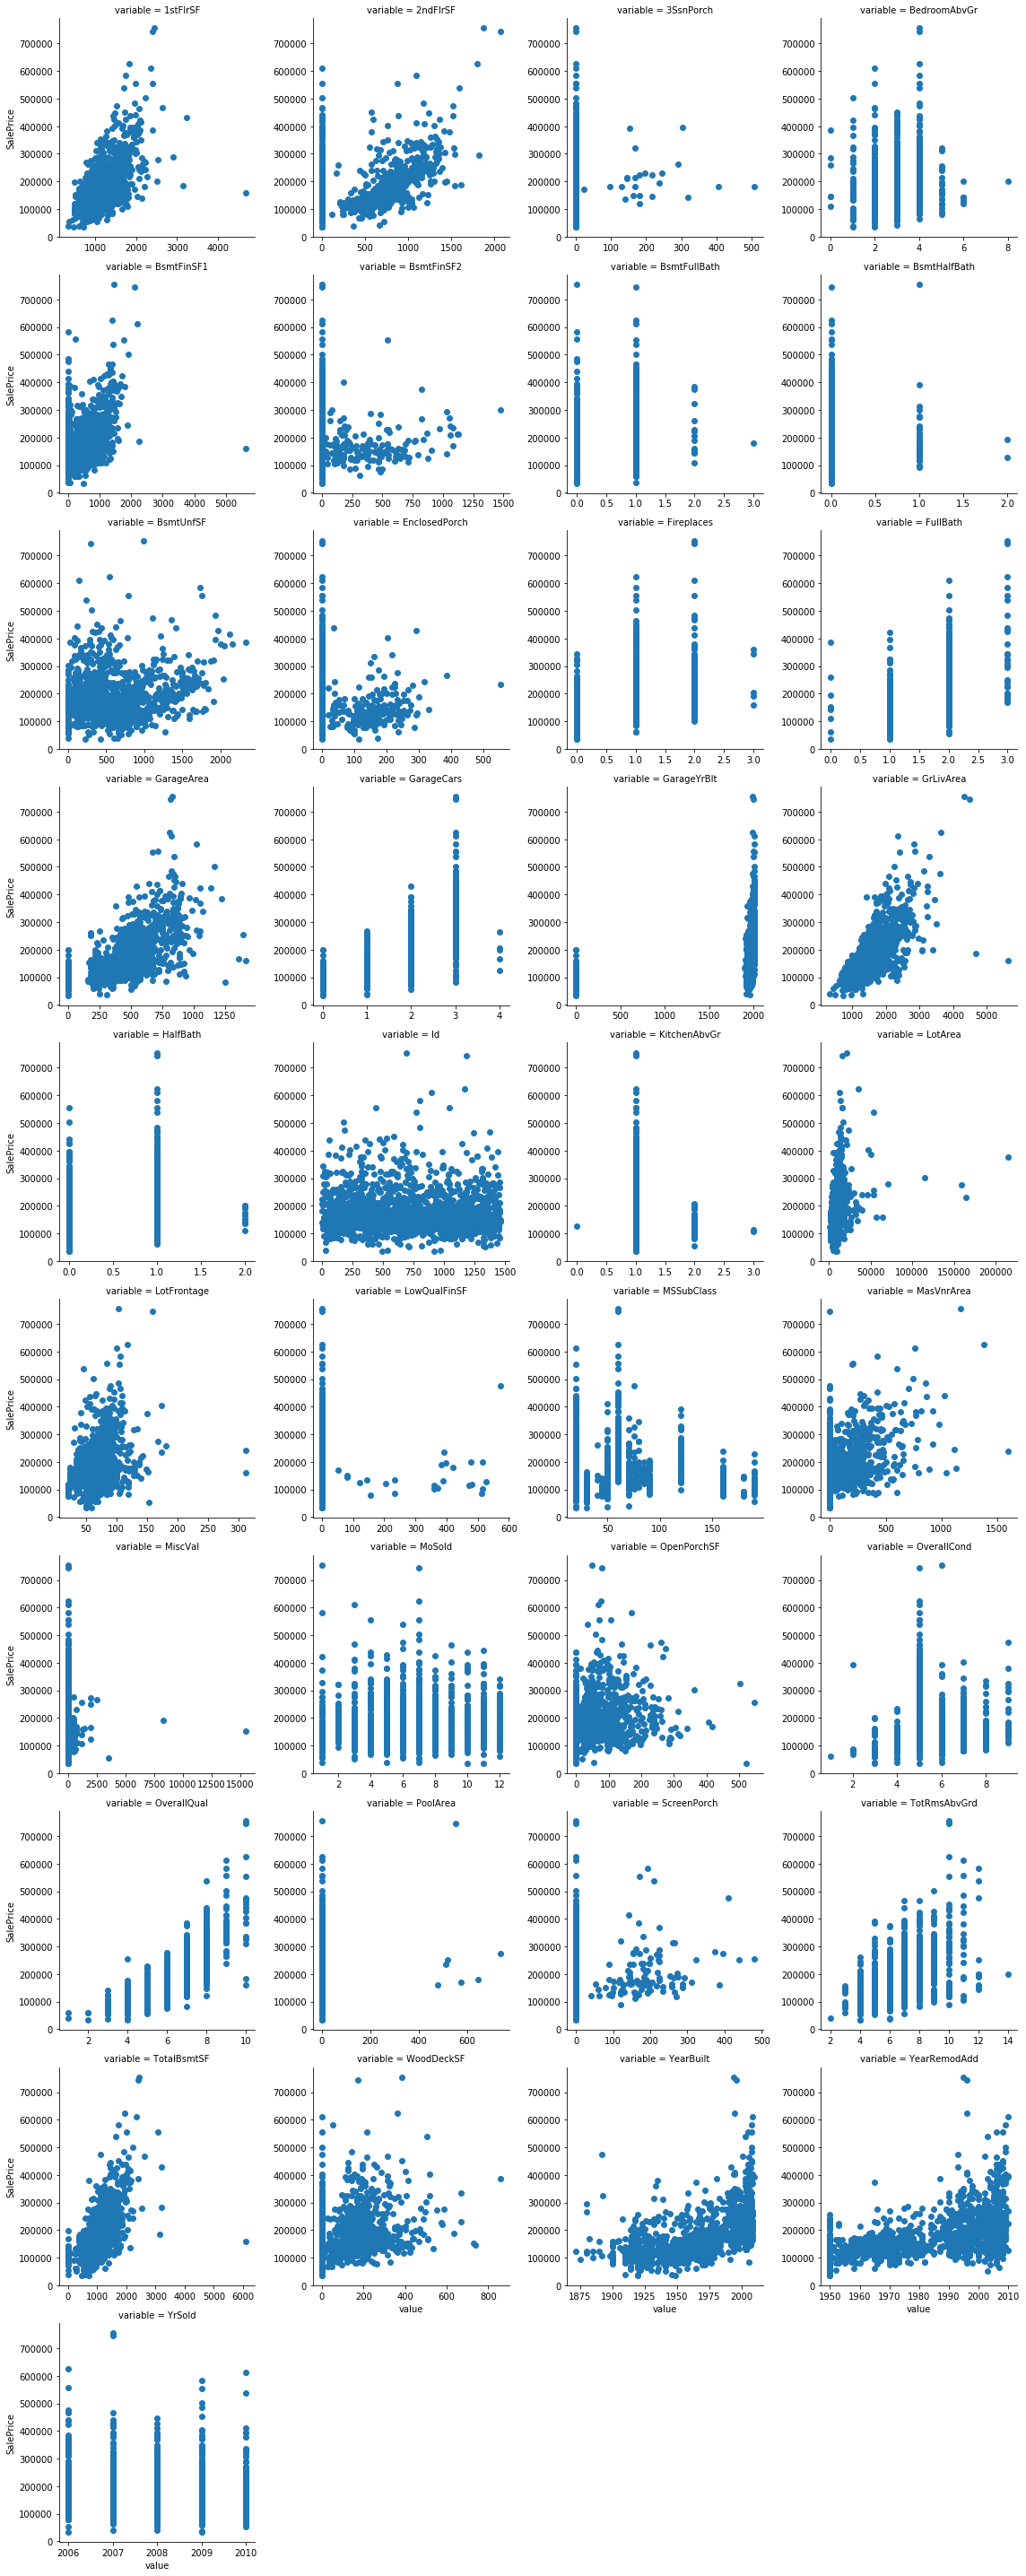

In [741]:
# We'll switch back to the original train dataframe for this visualization
tr = data[data["SalePrice"].isnull() == False]
y = tr["SalePrice"]
tr = tr.select_dtypes(include=['float64', "int64"])
tr.drop("SalePrice", axis=1, inplace=True)

f = pd.melt(pd.concat([tr,y],axis=1) , id_vars = ['SalePrice'] , value_vars = tr.columns )
g = sns.FacetGrid(f, col = 'variable' , col_wrap = 4, size = 4,sharex=False , sharey=False)
g = g.map(plt.scatter, "value", "SalePrice")

In [1079]:
data = data.drop(data[(data["GrLivArea"] > 4000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['TotalBsmtSF'] > 5000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['MasVnrArea'] > 1500) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['BsmtFinSF1'] > 4000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['LotFrontage'] > 250) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['OpenPorchSF'] > 400) & (data['SalePrice'] < 100000)].index)
data = data.drop(data[(data['1stFlrSF'] > 4000) & (data['SalePrice'] < 200000)].index)

# Visualizing Data & Using non-supervised methods to group observations to minimize variance (Pooled Models?)

Goal: get the best fit acheiveable with just a 2 + 1 dimension linear regression for ease of visualization and data exploration
 
Idea: use categorical features to reduce dimensionality and create groups or nodes that share the most in common, then fit a 2d multiple linear regression on these groupings generating an N number of 3d regression fit plots

General strategy:

PCA to reduce dimensionality of categorical values ==> unsupervised classifier to assign observations into groups ==> MLR to fit 2 numerical dimensions and select the best 2 precictors for this new "class" of houses 

In [6]:
target = pd.read_csv('MC_targetdf')['SalePrice']
Catdf = pd.read_csv('MC_Catdf').drop('Unnamed: 0', axis = 1)
Intdf = pd.read_csv('MC_Intdf').drop(['Unnamed: 0'], axis = 1)

In [7]:
lin = LinearRegression()
X = Intdf[['GrLivArea', 'OverallQual']]
y = target
print(lin.fit(X, y).score(X, y))
betas = lin.coef_
intercept = lin.intercept_


0.739972571422


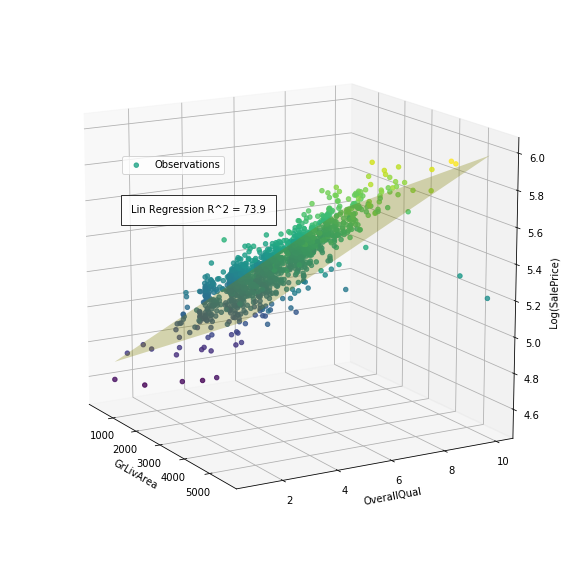

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

# plot the data points

X1 = Intdf.GrLivArea
X2 = Intdf.OverallQual
color = y.values

ax.scatter(X1, X2, y, c = y, alpha=.8, s = 20)
ax.view_init(15, 330)
#27, 0 to see fancy
# -20, 270 to look down property size plane
# 5, 330 for nice overview

# plot the plane which represents the true model
x_1 = np.linspace(min(X1), max(X1), 25)
x_2 = np.linspace(min(X2), max(X2), 25)
x_1, x_2 = np.meshgrid(x_1, x_2)
x_3 = betas[0]*x_1 + betas[1]*x_2 + intercept
surface_kwargs = dict(rstride=100, cstride=100, color='yellow', alpha=0.3)
ax.plot_surface(x_1, x_2, x_3, **surface_kwargs)
ax.set_xlabel('GrLivArea')
ax.set_ylabel('OverallQual')
ax.set_zlabel('Log(SalePrice)')
ax.legend(['Observations'], loc = [.2, .7])
ax.text(5, 2, 5.5, 'Lin Regression R^2 = 73.9',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
#plt.show()
plt.savefig('2+1d LinReg', bbox_inches=None, dpi = 300)

### Hypothesis: Degrees of variation partially arise from different "classes" of houses, grouped by factors that are difficult to manually disect 

### Research Question: Can we use clustering techniques to pre-sort houses by "likeness", splitting the data into nodes with reduced variance so that a better fit can be made on each node?

In [9]:
# Loading df's Constructed for this exercise 
# notes on df processing: 
# df separated into Intdf which contains all the continuous Numerica data w/o SalePrice, 
# Catdf is the categorical data, target is now log10(SalePrice)
# Categorical values numerically converted and NaN's imputed (mean) using custom NumericDataframe() class
# MSSubClass moved from Intdf to Catdf 

In [10]:
#loading in custom df's

target = pd.read_csv('MC_targetdf')['SalePrice']
Catdf = pd.read_csv('MC_Catdf').drop('Unnamed: 0', axis = 1)
Intdf = pd.read_csv('MC_Intdf').drop(['Unnamed: 0'], axis = 1)

In [26]:
# Creating tools to assist in drawing 3d plots

def plot_3d(coords, color, x_rot = 15, y_rot = 30, title = 'title'):
    fig = plt.figure(figsize = [10,10])
    color = color
    

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=color, s=10, alpha = 0.5)
    plt.viridis()
    plt.title(title)


    ax.view_init(x_rot, y_rot) # change these params to rotate cube
    plt.savefig(title, bbox_inches = None, dpi = 300) 
    plt.show()

# Unsupervised house grouping work-flow
<img src="MC_Schema.png">

In [12]:
# creating class for this workflow

class ClassRegressor:


#goal: build a class to smoothly apply PCA -> Classifier -> grouped LR onto df that have already been separated into - 
#continuous variables, Categorical variables that have been encoded, and the target 
  
    def __init__(self, Int, Cat):
        self.X = Int
        self.Cat = Cat

#Cat pipes takes in: number of PCA dimension, clustering connection, and number of clusters 
    def FitPipe(self, n_PCA_dims, knn, n_clusters):
        pca = PCA(n_components = n_PCA_dims)
        pca_out = pca.fit_transform(self.Cat) #create PCA transformed 
        connectivity = kneighbors_graph(pca_out, n_neighbors = knn, include_self=False)
        AGroup = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward', connectivity = connectivity)
        AGroup.fit(pca_out)
        self.Clusters = AGroup.labels_
        self.n_clusters = n_clusters
    
#spit out PCA coords just for graphin purposes    
    def pca_coords(self, n_PCA_dims):
        pca = PCA(n_components = n_PCA_dims)
        return(pca.fit_transform(self.Cat))
    
#attach groups to Cont df. split and get fit and score for each group    
    def FitLin(self, target):
        
        groups = list(set(self.Clusters))
        newX = deepcopy(self.X)
        newX['group'] = self.Clusters
        t2 = pd.DataFrame(target)
        t2['group'] = self.Clusters
        data = dict()
        y = dict()
        for n in range(0, self.n_clusters):
            data[n] = newX[newX.group == n].drop('group', axis = 1)
            y[n] = t2[t2.group == n].drop('group', axis = 1)
        
        columns = self.X.columns
        combos = list(itertools.product(columns, columns))
        combos = [list(combo) for combo in combos] 
        markers = [(combo[0] + ' : ' + combo[1]) for combo in combos]
        
        #fit and score 
        scores = dict()
        model = dict()
        max_score = dict()
        lin = dict()
        # fitting lin regression for every permutation of feature pairs
        # each group has to fit it's own model! 4 nodes = 4 models! 
        # sloppy and slow but it works for now
        
        for n in range(0, self.n_clusters):
            lin[n] = LinearRegression()
            model[n] = [lin[n].fit(data[n][combo], y[n]) for combo in combos]
            scores[n] = pd.DataFrame([lin[n].fit(data[n][combo], y[n]).score(data[n][combo], y[n]) for combo in combos])
            scores[n]['combo'] = markers
            scores[n].columns = ['score', 'combo']
            max_score[n] = scores[n].sort_values('score', ascending = False).iloc[0]
        return(max_score)
        

In [13]:
test = ClassRegressor(Intdf, Catdf) #instantiating 

In [14]:
#test.X.columns

In [15]:
test.FitPipe(n_PCA_dims = 3, knn = 20, n_clusters = 6) # forming PCA transformation of cat data, grouping with agglomerative clustering with KNN connectors
test_groups = test.Clusters
test_pca = test.pca_coords(3) # extra tool just to spit out coords of data in new PCA space. Dim's set to 3 for display purposes!

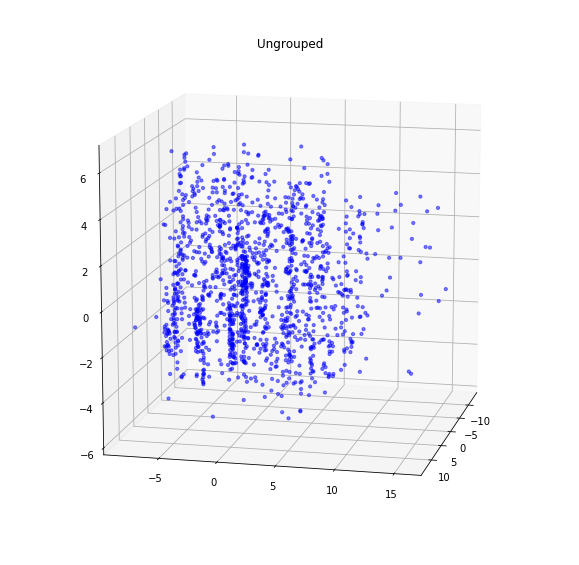

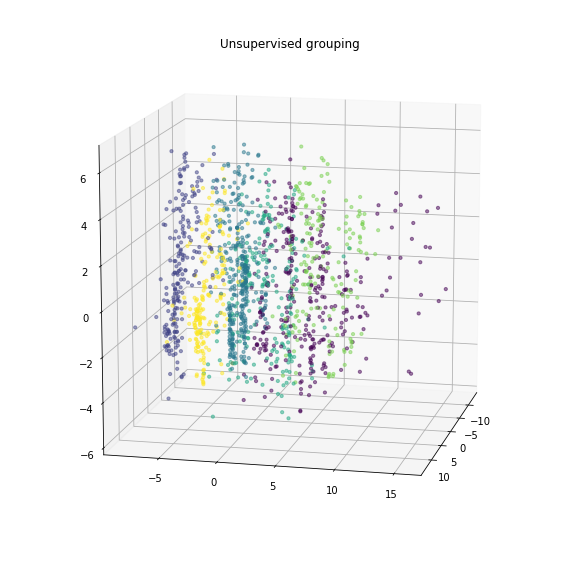

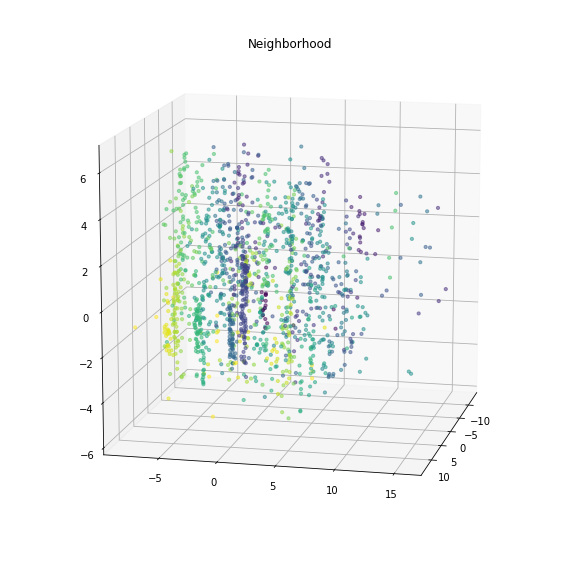

In [30]:
plot_3d(test_pca, 'b', 13, 13, 'Ungrouped')
plot_3d(test_pca, test_groups, 13, 13, 'Unsupervised grouping') #plotting points in PCA dims. colored by groups determined by clustering technique
#looks nice, but what do these vertical clusters pertain to? 
# let's color the PCA vectorized data by categories and explore 
# i'm just going to plot neighborhoods, that's the only relevant one
columns = Catdf.columns


plot_3d(test_pca, Catdf['Neighborhood'], 13, 13,  title = 'Neighborhood')


In [17]:
test.FitLin(target) # now I have some suitable nodes, let me do 2+1 lin regression on each node and find best predictors

{0: score                    0.79519
 combo    OverallQual : GrLivArea
 Name: 84, dtype: object, 1: score                    0.764286
 combo    OverallQual : GarageArea
 Name: 95, dtype: object, 2: score                    0.682197
 combo    OverallQual : GarageCars
 Name: 94, dtype: object, 3: score                 0.735683
 combo    GrLivArea : YearBuilt
 Name: 494, dtype: object, 4: score                   0.62534
 combo    OverallQual : 1stFlrSF
 Name: 81, dtype: object, 5: score                    0.859766
 combo    GarageCars : OverallQual
 Name: 842, dtype: object}

## Next steps

- Improve PCA, clustering parameters with a grid search
- Add methods to predict grouping of test data and assign them to a 'class'
    - potentially with a decision tree method trained on classifications we've defined with train data
- Merge preprocessing grouping with full MLM methods group is working on
- *Bonus* add a method that automatically draws new plots for each node 

# More Transformation
Some of the features are numerical, but their real value
is in their distinctness from each other- so we can
convert these features to "categorical".   

In [1080]:
 to_category = [
    "Id", "MSSubClass", "OverallCond",
    "YrSold", "MoSold", "OverallQual",
    "YearBuilt", "YearRemodAdd", "GarageYrBlt",
     "GarageCars", "Fireplaces", "FullBath",
     "HalfBath", "TotRmsAbvGrd", "BsmtFullBath",
     "BsmtHalfBath"
]
for col in to_category:
    data[col] = data[col].astype("str")

We can check for skewed distributions, and normalize them.

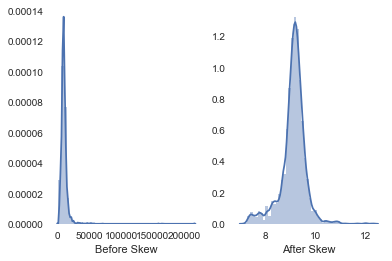

In [1081]:
fig, axs = plt.subplots(ncols=2)
before_skew = data["LotArea"]

# Applying logarithmic transform to skewed features
# This code was pulled from Alexandru Papiu:
# https://www.kaggle.com/apapiu/regularized-linear-models

numeric_feats = data.dtypes[data.dtypes != "object"].index
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index

log = lambda x: np.log1p(x)
data[skewed_feats] = data[skewed_feats].apply(log)
after_skew = data["LotArea"]
sns.distplot(before_skew, ax=axs[0], axlabel="Before Skew")
sns.distplot(after_skew, ax=axs[1], axlabel="After Skew")

We are especially interested in making sure the values are distributed normally. A probability plot will assist with this as well.

In [1082]:
y = data["SalePrice"].dropna()

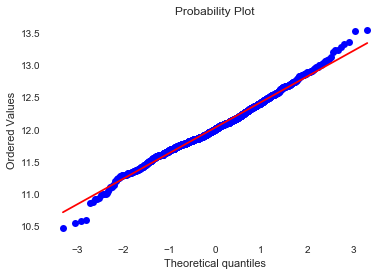

In [1069]:
fig = plt.figure()
stats.probplot(y, plot=plt)
plt.show()

# Dummy Variables and Feature Selection

In [1083]:
test = data[data['SalePrice'].isnull()]
data = data[data['SalePrice'].notnull()]
data.drop("SalePrice", axis=1, inplace=True)

In [1084]:
data = pd.get_dummies(data).fillna(0)

In [1085]:
selector = SelectKBest(score_func=f_regression, k=10).fit(data, y)
scores = selector.pvalues_
scores /= scores.max()

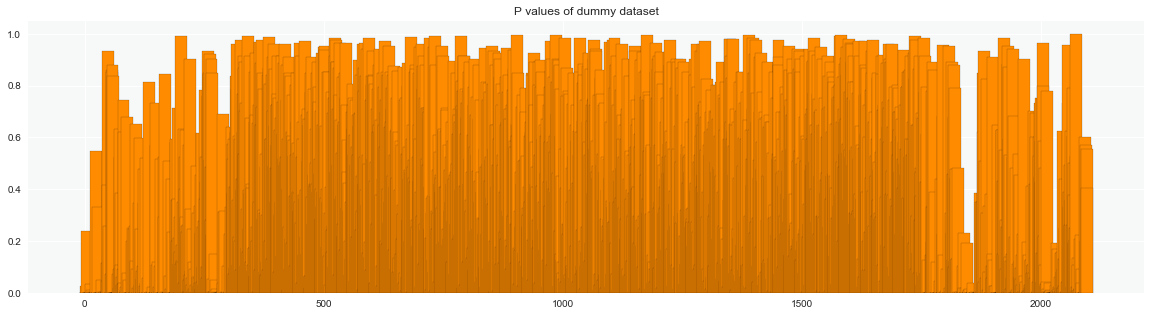

In [1044]:
X_indices = np.arange(data.shape[-1])
fig, ax = plt.subplots(figsize = (20,5))
plt.bar(X_indices, (scores), width=25,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black', linewidth=.15)
ax.set_title("P values of dummy dataset")
ax.set_axis_bgcolor("#F7F9F8")

Many variables have very high P values, meaning there is little chance they have influence over the Sale Price of the house.

In [1086]:
x = np.where(scores <= .05)
data = data[data.columns[x]]
print("Total columns after creating dummy variables and filtering by p-value {}".format(len(data.columns)))

Total columns after creating dummy variables and filtering by p-value 437


In [1087]:
lasso = LassoCV().fit(data, y)
model = SelectFromModel(lasso, threshold=0.009, prefit=True)
data = data[data.columns[model.get_support()]]
print("Total columns after Lasso feature selection {}".format(data.shape[1]))

Total columns after Lasso feature selection 99


In [1088]:
### Correlation Plots
def corrgraphs(df):
    neg = df.corr()[df.corr() < -0.5]
    neg = neg.dropna(how="all", axis=1)
    neg = neg.dropna(how="all", axis=0)
    pos = df.corr()[df.corr() > 0.5]
    pos = pos[pos < 1.0]
    pos = pos.dropna(how="all", axis=1)
    pos = pos.dropna(how="all", axis=0)
    return (neg, pos)
neg, pos = corrgraphs(data)

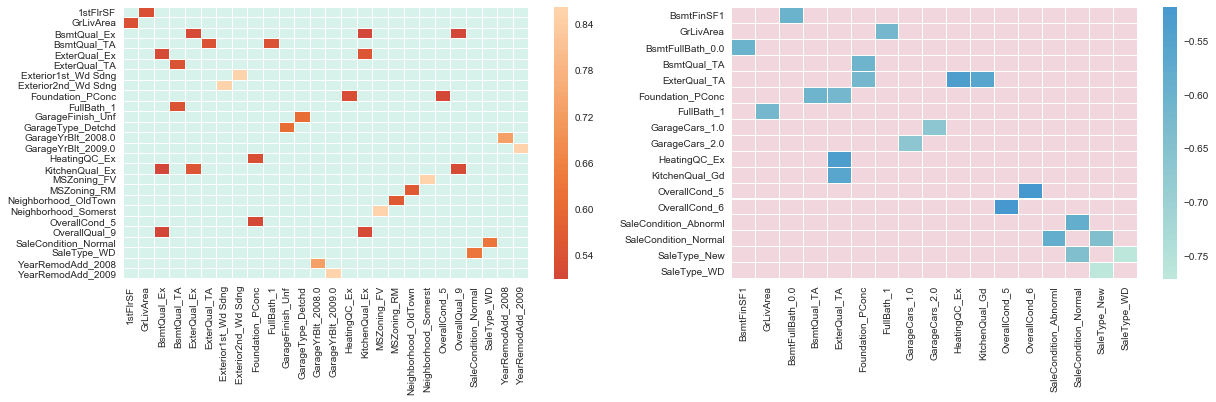

In [1089]:
def plot_corrgraphs(neg, pos):
    fig, axs = plt.subplots(ncols=2, figsize=(20,5))
    pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
    pos_heatmap.set(axis_bgcolor="#D6F2EB")
    neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
    neg_heatmap.set(axis_bgcolor="#F2D6DD")
    return
plot_corrgraphs(neg, pos)

# Everything below here is not presentation ready!

In [1058]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# def vif_filter(df):
#     vif = pd.DataFrame()
#     vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
#     vif["Features"] = df.columns
#     return vif
# vif = vif_filter(data)
# vif

In [1104]:
# df = train_dummies[vif[vif["VIF Factor"] < 10]["features"]]
# vif
# vif["VIF Factor"] = round(vif["VIF Factor"])
# vif.groupby("VIF Factor").count()["features"] - 1

In [1090]:
X_train, X_test, y_train, y_test = train_test_split(data, y)

# Modeling

In [1091]:
class RunModels():
    
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_dict = {}
    
        # Prints R2 and RMSE scores
    def get_score(self, model, name, pred, y):
        r2score = r2_score(pred, y)
        rmse = np.sqrt(mean_squared_error(pred, y))
        self.model_dict[name] = {"r2score": r2score,
                                 "RMSE": rmse,
                                 "preds": pred,
                                 "model_params": model}
        print('R2: {}'.format(r2score))
        print('RMSE: {}'.format(rmse))


    # Shows scores for train and validation sets    
    def train_test(self, model, name):
        pred = model.predict(self.X_test)
        self.get_score(model, name, pred, self.y_test)

    def __call__(self, models):
        for name, model in models.items():
            print(name)
            print("-" * len(name))
            model.fit(self.X_train, self.y_train)
            self.train_test(model, name)
            print("."*25)
        return self.model_dict

In [1092]:
models = {
    "Linear": LinearRegression(),
    "LassoCV": LassoCV(normalize=True, cv=6),
    "ElasticNet": ElasticNetCV(alphas=[.001], max_iter=5000),
    "RandomForest": RandomForestRegressor(n_estimators=100),
    "GradientBoost": GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,
                                               max_depth=2, max_features=10,loss="huber"),
    "XGBoost": xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                    learning_rate=0.05, max_depth=3, 
                                    min_child_weight=1.7817, n_estimators=2200,
                                    reg_alpha=0.4640, reg_lambda=0.8571,
                                    subsample=0.5213, silent=1,
                                    random_state =7, nthread = -1),
    "BagRegressor": BaggingRegressor(base_estimator=ElasticNetCV(alphas=[.001],max_iter=5000),
                                     n_estimators=10)    
}
model_scores = RunModels(X_train, y_train, X_test, y_test)(models)

Linear
------
R2: 0.9156151668465994
RMSE: 0.10768373294202949
.........................
LassoCV
-------
R2: 0.9152092763929047
RMSE: 0.1056798249943665
.........................
ElasticNet
----------
R2: 0.9113117529418865
RMSE: 0.10705433286783056
.........................
RandomForest
------------
R2: 0.8511219993090443
RMSE: 0.1365538362887699
.........................
GradientBoost
-------------
R2: 0.9178473080851627
RMSE: 0.10435606342588083
.........................
XGBoost
-------
R2: 0.9084768683387909
RMSE: 0.10885834569791925
.........................
BagRegressor
------------
R2: 0.9101159436220916
RMSE: 0.10657670180672728
.........................


KeyError: "['Linear'] not in index"

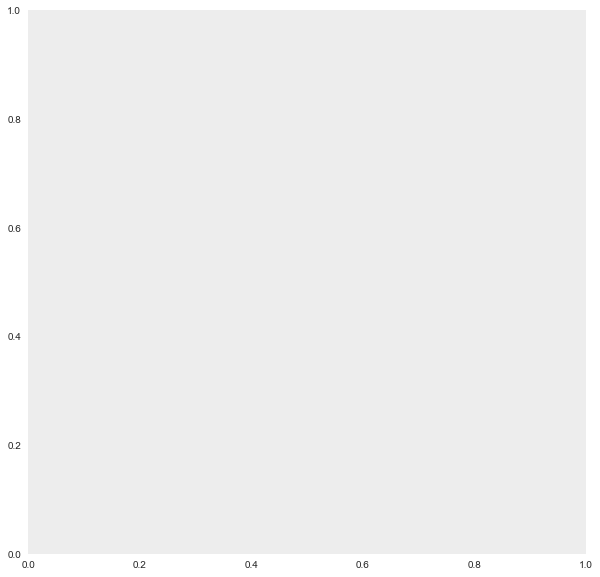

In [1113]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_bgcolor("#ededed")
sns.set_style("dark")
colors = ["#ffa500","#daff00","#ff2500","#005aff","#00ffa5","#a500ff"]
i = 0
for name, val in model_scores.items():
    if i == len(model_scores) - 1:
        break
    preds = pd.DataFrame({"preds":model_scores[name]["preds"], "true":y_test})
    preds["residuals"] = np.exp(preds["true"]) - np.exp(preds["preds"])
    sns.regplot("preds","residuals", data = preds, ax=ax.twinx(), fit_reg=False,
                ci=0, color=colors[i], scatter_kws={'alpha':1})
    i += 1

In [1009]:
# grid_search_rf = joblib.dump(grid_search, "grid_search_rf_dummies.pkl")

In [855]:
# grid_search.score(X_test, y_test)

In [856]:
# grid_search_xgb = joblib.load("grid_search_xgb_dummies.pkl")
# print(rmse_cv(grid_search_xgb).mean())
# grid_search_xgb.score(X_test, y_test)

In [883]:
# # AdaBoost
# from sklearn.ensemble import AdaBoostRegressor
# ada = AdaBoostRegressor(base_estimator=rf)
# ada.fit(X_train, y_train)
# train_test(ada, X_train, X_test, y_train, y_test)

In [885]:
# gboost_predict_stack = gboost.predict(X_test_stack)

In [724]:
# scores = cross_val_score(model_xgb, X_train, y_train, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [872]:
combined_pred = (
    lm.predict(X_test) +
    model_xgb.predict(X_test) +
    bag.predict(X_test) +
    model_lasso.predict(X_test) +
    elastic_net.predict(X_test) +
    gboost.predict(X_test)) / 6
print('R2: {}'.format(r2_score(combined_pred, y_test)))

R2: 0.9140259815732682


In [873]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
print(rmse(combined_pred, y_test))

0.1130386872692908


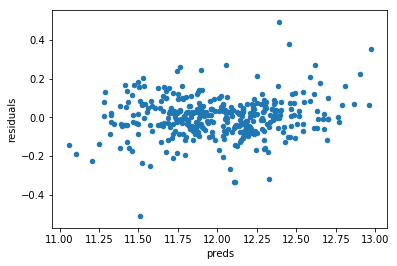

In [64]:
preds = pd.DataFrame({"preds":combined_pred, "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


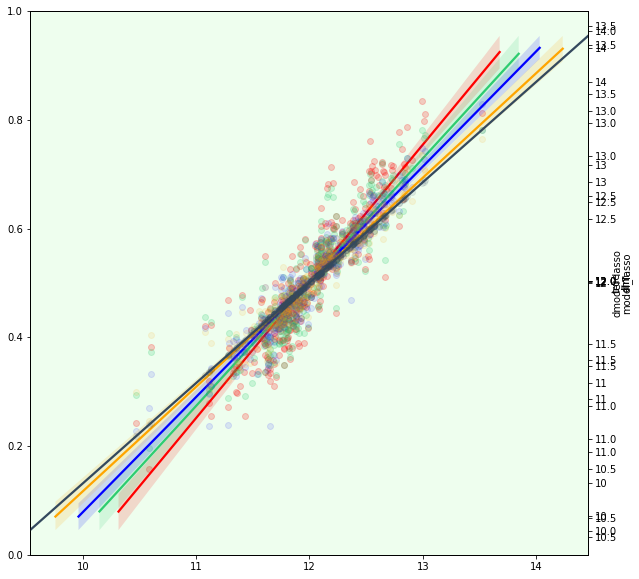

In [1093]:
all_preds = pd.DataFrame({#"preds": combined_pred,
                          "lm": lm.predict(X_test),
                          "model_lasso": model_lasso.predict(X_test),
                            "dlm": dlm_predict,
                            "dmodel_lasso": dmodel_lasso_predict,
#                           "model_xgb": model_xgb.predict(X_test),
#                           "elastic_net": elastic_net.predict(X_test),
#                           "bag_regressor": bag.predict(X_test),
                          "true":y_test
                         })
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_bgcolor("#eefeee")
# sns.regplot(x='true', y='preds', data=all_preds, ax=ax, color="#95a5a6", scatter_kws={'alpha':.3})
ax2 = ax.twinx()
sns.regplot(x='true', y='lm', data=all_preds, ax=ax2, color="r", scatter_kws={'alpha':0.2})
ax3 = ax.twinx()
sns.regplot(x='true', y='model_lasso', data=all_preds, ax=ax3, color="#2ecc71", scatter_kws={'alpha':0.2})
ax2 = ax.twinx()
sns.regplot(x='true', y='dlm', data=all_preds, ax=ax2, color="b", scatter_kws={'alpha':0.1})
ax3 = ax.twinx()
sns.regplot(x='true', y='dmodel_lasso', data=all_preds, ax=ax3, color="orange", scatter_kws={'alpha':0.1})
# ax3 = ax.twinx()
# sns.regplot(x='true', y='bag_regressor', data=all_preds, ax=ax3, color="#2ecc71", scatter_kws={'alpha':0})

# ax4 = ax.twinx()
# sns.regplot(x='true', y='elastic_net', data=all_preds, ax=ax4, color="#3498db", scatter_kws={'alpha':0})

# ax5 = ax.twinx()
# sns.regplot(x='true', y='model_xgb', data=all_preds, ax=ax5, color="#FF69B4", scatter_kws={'alpha':.4})
ax6 = ax.twinx()
sns.regplot(x='true', y='true', data=all_preds, ax=ax6, color="#34495e", scatter_kws={'alpha': 0.1})

In [73]:
print(mean_absolute_error(y_test, combined_pred))
print(mean_absolute_error(y_test, elastic_net.predict(X_test)))
print(mean_absolute_error(y_test, model_lasso.predict(X_test)))
print(mean_absolute_error(y_test, model_xgb.predict(X_test)))
print(mean_absolute_error(y_test, lm.predict(X_test)))

0.07530413366151853
0.07828444201268202
0.07921988167186991
0.0854422582531566
0.08495947051515414


In [62]:
print(explained_variance_score(y_test, combined_pred))
print(explained_variance_score(y_test, elastic_net.predict(X_test)))
print(explained_variance_score(y_test, model_lasso.predict(X_test)))
print(explained_variance_score(y_test, model_xgb.predict(X_test)))

0.9283142307085968
0.9248232057787331
0.9221032348473697
0.9069201957865901


In [63]:
print(mean_squared_error(y_test, combined_pred))
print(mean_squared_error(y_test, elastic_net.predict(X_test)))
print(mean_squared_error(y_test, model_lasso.predict(X_test)))
print(mean_squared_error(y_test, model_xgb.predict(X_test)))

0.010853276675726952
0.011390469662362054
0.011788577840345375
0.014120293219261967


In [244]:
predictions_df = pd.DataFrame([model_lasso_predict, elastic_net_predict,
                               gboost_predict, model_xgb_predict,
                               lm_predict])
predictions_df = predictions_df.T.rename(index=str, columns = {0:"Lasso",
                                                               1:"ElasticNet",
                                                               2:"GradientBoost",
                                                               3:"XGB", 4:"LM" })
len(predictions_df)
predictions_df_stack = pd.DataFrame([model_lasso_predict_stack, elastic_net_predict_stack,
                                     gboost_predict_stack, model_xgb_predict_stack,
                                     lm_predict_stack])
predictions_df_stack = predictions_df_stack.T.rename(index=str, columns = {0:"Lasso",
                                                                           1:"ElasticNet",
                                                                           2:"GradientBoost",
                                                                           3:"XGB", 4:"LM" })
y_test1 = pd.DataFrame(y_test.reset_index()).drop("index", axis=1)["SalePrice"]
stack_gboost = GradientBoostingRegressor(n_estimators=2000)
stack_gboost.fit(predictions_df, y_test1)
# rf_stack = RandomForestRegressor(n_estimators=2000, max_depth=2).fit(predictions_df, y_test1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [194]:
# lm = LinearRegression().fit(predictions_df, y_test1)


# print(lm.score(predictions_df_stack, y_test_stack))
# print(rmse_cv_stack(lm, predictions_df_stack, y_test_stack).mean())

0.8005037908630646
0.132631237420204


In [218]:
# Calculate RMSE
def rmse_cv_stack(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)
print(stack_gboost.score(predictions_df_stack, y_test_stack))
print(rmse_cv_stack(stack_gboost, predictions_df_stack, y_test_stack).mean())

0.8724407189572899
0.1369813452012161


In [401]:
# PCA workflow not being used atm.

# pca = PCA()
# # scaled_data = scale(X_train.T)
# # pca.fit(scaled_data)    

# pca.fit(scale(X_train))
# pca_data = pca.transform(scale(X_train))

# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
# plt.bar(left=range(1,6), height=per_var[:5], tick_label=labels[:5])
# plt.show()

# pca_df = pd.DataFrame(pca_data)
# plt.scatter(pca_df[0], pca_df[1], pca_df[3], c=["red","blue","green"])

In [34]:
# le = LabelEncoder()
# le.fit(train["KitchenQual"])
# list(le.classes_)
# tdf = pd.DataFrame([le.transform(train["KitchenQual"]),
#                    train["KitchenQual"],
#                    train["SalePrice"]]).T
# tdf.rename(columns={0:"Encoded", 1:"Original", 2:"SalePrice"}, inplace=True)

In [9]:
# def ordinal_to_numeric(df):
#     for i in range(len(df.columns)-1):
#         is_cat = df.iloc[:,i].values.any() in ("Gd","Ex","TA","Fa","Po")
#         if is_cat == True:
#             df[df.columns[i]] = df[df.columns[i]].map({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1})
#     return df